In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/raw/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df = df.drop(columns=['id'])

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df['bmi'] = imputer.fit_transform(df[['bmi']])

In [5]:
df['hypertension'] = df['hypertension'].map({0: 'No', 1: 'Yes'})
df['heart_disease'] = df['heart_disease'].map({0: 'No', 1: 'Yes'})

In [6]:
from sklearn.preprocessing import LabelEncoder


categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
X = df.drop(columns=['stroke'])
y = df['stroke']

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]

threshold = 0.3
y_pred = (y_probs >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with threshold {threshold}: {accuracy}")

precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")


Accuracy with threshold 0.3: 0.9148727984344422
Precision for class 0: 95.38%
Recall for class 0: 95.68%
F1 Score for class 0: 95.53%
Precision for class 1: 10.64%
Recall for class 1: 10.00%
F1 Score for class 1: 10.31%


XGBoost

In [10]:
from xgboost import XGBClassifier

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

clf = XGBClassifier(max_depth=5, random_state=42, scale_pos_weight=scale_pos_weight)
clf.fit(X_train, y_train)

y_probs = clf.predict_proba(X_test)[:, 1]

# overpredict strokes
threshold = 0.1
y_pred = (y_probs >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")

19.542713567839197
Accuracy: 0.8111545988258317
Precision for class 0: 97.33%
Recall for class 0: 82.41%
F1 Score for class 0: 89.25%
Precision for class 1: 14.07%
Recall for class 1: 56.00%
F1 Score for class 1: 22.49%


In [11]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    print(f"Recall for threshold {threshold}: {recall_1 * 100:.2f}%")


Recall for threshold 0.1: 56.00%
Recall for threshold 0.2: 48.00%
Recall for threshold 0.3: 42.00%
Recall for threshold 0.4: 34.00%
Recall for threshold 0.5: 28.00%


In [12]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.98]:
    y_pred = (y_probs >= threshold).astype(int)
    # Calculate the metrics for each threshold
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    print(f"Threshold: {threshold}")
    print(f"Precision for class 1: {precision_1 * 100:.2f}%")
    print(f"Recall for class 1: {recall_1 * 100:.2f}%")
    print(f"F1 Score for class 1: {f1_1 * 100:.2f}%\n")


Threshold: 0.1
Precision for class 1: 14.07%
Recall for class 1: 56.00%
F1 Score for class 1: 22.49%

Threshold: 0.2
Precision for class 1: 17.65%
Recall for class 1: 48.00%
F1 Score for class 1: 25.81%

Threshold: 0.3
Precision for class 1: 20.00%
Recall for class 1: 42.00%
F1 Score for class 1: 27.10%

Threshold: 0.4
Precision for class 1: 22.67%
Recall for class 1: 34.00%
F1 Score for class 1: 27.20%

Threshold: 0.5
Precision for class 1: 25.00%
Recall for class 1: 28.00%
F1 Score for class 1: 26.42%

Threshold: 0.98
Precision for class 1: 0.00%
Recall for class 1: 0.00%
F1 Score for class 1: 0.00%



In [13]:

# Define a range of thresholds and scale_pos_weight values
thresholds = np.linspace(0.05, 0.5, 10)  # Vary the threshold between 0.05 and 0.5
scale_pos_weights = [1, 2, 3, 5, 10, 20]  # Vary scale_pos_weight

# Loop through different scale_pos_weight values
for scale_pos_weight in scale_pos_weights:
    print(f"\nTesting scale_pos_weight = {scale_pos_weight}")

    # Initialize and train the model with the current scale_pos_weight
    clf = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, max_depth=5)
    clf.fit(X_train, y_train)

    # Get the predicted probabilities
    y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (stroke)

    # Loop through different thresholds
    for threshold in thresholds:
        print(f"  Testing threshold = {threshold:.2f}")
        
        # Apply the threshold to make predictions
        y_pred = (y_probs >= threshold).astype(int)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision_0 = precision_score(y_test, y_pred, pos_label=0)
        recall_0 = recall_score(y_test, y_pred, pos_label=0)
        f1_0 = f1_score(y_test, y_pred, pos_label=0)

        precision_1 = precision_score(y_test, y_pred, pos_label=1)
        recall_1 = recall_score(y_test, y_pred, pos_label=1)
        f1_1 = f1_score(y_test, y_pred, pos_label=1)

        # Print metrics for the current threshold and scale_pos_weight
        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    Precision for class 0: {precision_0 * 100:.2f}%")
        print(f"    Recall for class 0: {recall_0 * 100:.2f}%")
        print(f"    F1 Score for class 0: {f1_0 * 100:.2f}%")
        
        print(f"    Precision for class 1: {precision_1 * 100:.2f}%")
        print(f"    Recall for class 1: {recall_1 * 100:.2f}%")
        print(f"    F1 Score for class 1: {f1_1 * 100:.2f}%")
        print("-" * 50)



Testing scale_pos_weight = 1
  Testing threshold = 0.05
    Accuracy: 0.8376
    Precision for class 0: 97.52%
    Recall for class 0: 85.08%
    F1 Score for class 0: 90.88%
    Precision for class 1: 16.67%
    Recall for class 1: 58.00%
    F1 Score for class 1: 25.89%
--------------------------------------------------
  Testing threshold = 0.10
    Accuracy: 0.8845
    Precision for class 0: 96.82%
    Recall for class 0: 90.84%
    F1 Score for class 0: 93.74%
    Precision for class 1: 19.09%
    Recall for class 1: 42.00%
    F1 Score for class 1: 26.25%
--------------------------------------------------
  Testing threshold = 0.15
    Accuracy: 0.9061
    Precision for class 0: 96.20%
    Recall for class 0: 93.83%
    F1 Score for class 0: 95.00%
    Precision for class 1: 18.92%
    Recall for class 1: 28.00%
    F1 Score for class 1: 22.58%
--------------------------------------------------
  Testing threshold = 0.20
    Accuracy: 0.9198
    Precision for class 0: 95.97%
   

In [14]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define a range of thresholds and scale_pos_weight values
thresholds = np.linspace(0.05, 0.5, 10)  # Vary the threshold between 0.05 and 0.5
scale_pos_weights = [1, 2, 3, 5, 10, 20]  # Vary scale_pos_weight

# Variables to track the best threshold and scale_pos_weight
best_threshold = None
best_scale_pos_weight = None
best_f1_1 = 0  # Initialize the best F1 score for class 1 (stroke) as 0
best_recall_1 = 0

# Loop through different scale_pos_weight values
for scale_pos_weight in scale_pos_weights:
    #print(f"\nTesting scale_pos_weight = {scale_pos_weight}")

    # Initialize and train the model with the current scale_pos_weight
    clf = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, max_depth=5)
    clf.fit(X_train, y_train)

    # Get the predicted probabilities
    y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (stroke)

    # Loop through different thresholds
    for threshold in thresholds:
        #print(f"  Testing threshold = {threshold:.2f}")
        
        # Apply the threshold to make predictions
        y_pred = (y_probs >= threshold).astype(int)

        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision_0 = precision_score(y_test, y_pred, pos_label=0)
        recall_0 = recall_score(y_test, y_pred, pos_label=0)
        f1_0 = f1_score(y_test, y_pred, pos_label=0)

        precision_1 = precision_score(y_test, y_pred, pos_label=1)
        recall_1 = recall_score(y_test, y_pred, pos_label=1)
        f1_1 = f1_score(y_test, y_pred, pos_label=1)

         # Print metrics for the current threshold and scale_pos_weight
        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    Precision for class 0: {precision_0 * 100:.2f}%")
        print(f"    Recall for class 0: {recall_0 * 100:.2f}%")
        print(f"    F1 Score for class 0: {f1_0 * 100:.2f}%")
        
        print(f"    Precision for class 1: {precision_1 * 100:.2f}%")
        print(f"    Recall for class 1: {recall_1 * 100:.2f}%")
        print(f"    F1 Score for class 1: {f1_1 * 100:.2f}%")
        print("-" * 50)

        # best combination of threshold and scale_pos_weight based on F1 score for class 1
        if f1_1 > best_f1_1:
            best_f1_1 = f1_1
            best_threshold = threshold
            best_scale_pos_weight = scale_pos_weight
            best_recall_1 = recall_1

# Print the best threshold and scale_pos_weight based on F1 score for class 1
print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Best scale_pos_weight: {best_scale_pos_weight}")
print(f"Best F1 Score for class 1: {best_f1_1 * 100:.2f}%")
print(f"Best Recall Score for class 1: {best_recall_1 * 100:.2f}%")


    Accuracy: 0.8376
    Precision for class 0: 97.52%
    Recall for class 0: 85.08%
    F1 Score for class 0: 90.88%
    Precision for class 1: 16.67%
    Recall for class 1: 58.00%
    F1 Score for class 1: 25.89%
--------------------------------------------------
    Accuracy: 0.8845
    Precision for class 0: 96.82%
    Recall for class 0: 90.84%
    F1 Score for class 0: 93.74%
    Precision for class 1: 19.09%
    Recall for class 1: 42.00%
    F1 Score for class 1: 26.25%
--------------------------------------------------
    Accuracy: 0.9061
    Precision for class 0: 96.20%
    Recall for class 0: 93.83%
    F1 Score for class 0: 95.00%
    Precision for class 1: 18.92%
    Recall for class 1: 28.00%
    F1 Score for class 1: 22.58%
--------------------------------------------------
    Accuracy: 0.9198
    Precision for class 0: 95.97%
    Recall for class 0: 95.58%
    F1 Score for class 0: 95.77%
    Precision for class 1: 20.37%
    Recall for class 1: 22.00%
    F1 Score

In [15]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_cv = cross_val_predict(clf, X, y, cv=5)

precision_0 = precision_score(y, y_pred_cv, pos_label=0)
recall_0 = recall_score(y, y_pred_cv, pos_label=0)
f1_0 = f1_score(y, y_pred_cv, pos_label=0)

precision_1 = precision_score(y, y_pred_cv, pos_label=1)
recall_1 = recall_score(y, y_pred_cv, pos_label=1)
f1_1 = f1_score(y, y_pred_cv, pos_label=1)

cv_scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f}")

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")


Cross-Validation Accuracy: 0.9115
Precision for class 0: 96.15%
Recall for class 0: 94.49%
F1 Score for class 0: 95.31%
Precision for class 1: 19.52%
Recall for class 1: 26.10%
F1 Score for class 1: 22.34%


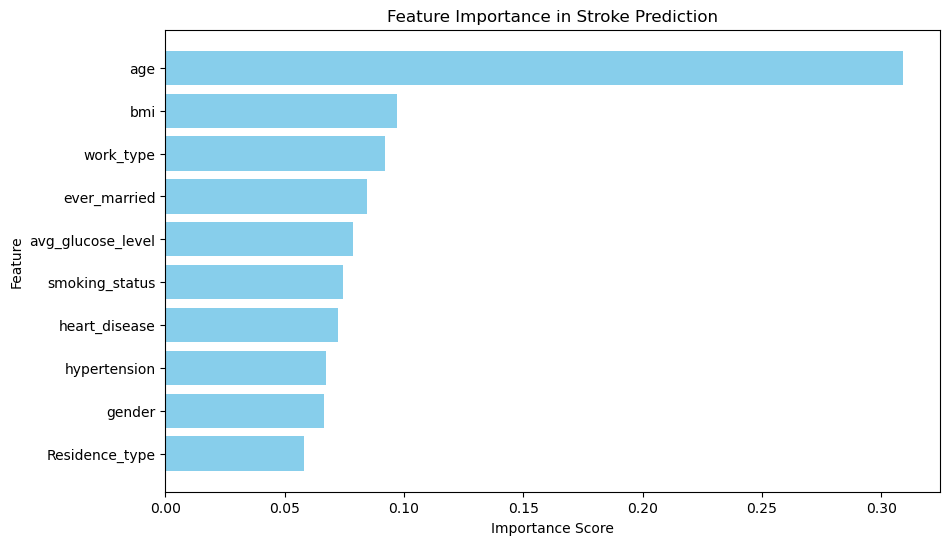

,Feature,Importance
1,age,0.309197
8,bmi,0.097032
5,work_type,0.091959
4,ever_married,0.084381
7,avg_glucose_level,0.078716
9,smoking_status,0.074333
3,heart_disease,0.072336
2,hypertension,0.067433
0,gender,0.066484
6,Residence_type,0.058127


In [16]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = clf.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Stroke Prediction')
plt.gca().invert_yaxis()
plt.show()

importance_df


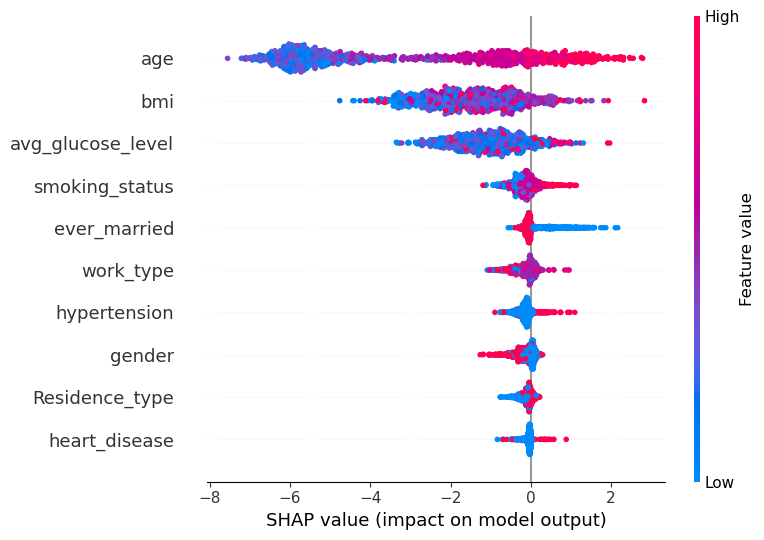

In [17]:
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


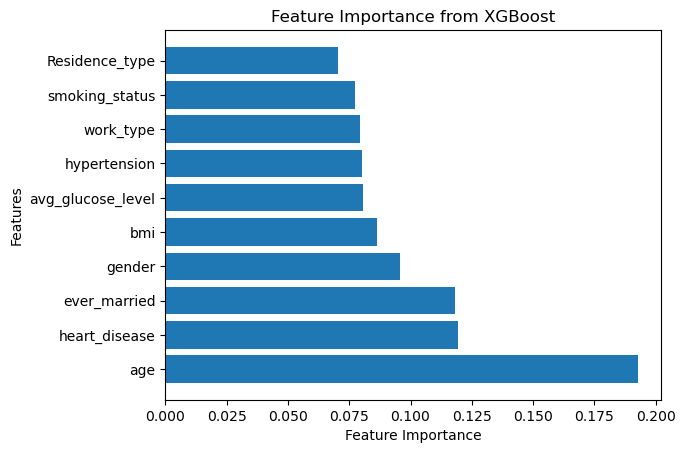

In [18]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming clf is your trained XGBoost model
clf = XGBClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Get feature importance
importances = clf.feature_importances_

# Sort the importances in descending order
sorted_idx = importances.argsort()[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = X_train.columns[sorted_idx]

# Plot the feature importances
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost')
plt.show()


In [19]:
from xgboost import XGBClassifier

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

clf = XGBClassifier(max_depth=5, random_state=42, scale_pos_weight=scale_pos_weight)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")

19.542713567839197
Accuracy: 0.923679060665362
Precision for class 0: 96.27%
Recall for class 0: 95.68%
F1 Score for class 0: 95.98%
Precision for class 1: 25.00%
Recall for class 1: 28.00%
F1 Score for class 1: 26.42%
